In [0]:
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, DepthwiseConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import cv2
from keras import backend as K
import os
import glob
import h5py
import shutil as cf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import tensorflow as tf
import keras
print(tf.__version__)
%matplotlib inline

Using TensorFlow backend.


1.14.0


In [0]:
#install depenencies
!pip install -q kaggle

In [ ]:
#upload the credentials of the kaggle account
from google.colab import files
files.upload()

In [0]:
#before importing the dataset we want to use this code
# The Kaggle API client expects this file to be in ~/.kaggle,
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
#import the dataset we want to use for our project
!kaggle competitions download -c aptos2019-blindness-detection

100% 8.01G/8.01G [02:34<00:00, 47.2MB/s]

 99% 1.48G/1.50G [00:25<00:00, 45.2MB/s]
100% 1.50G/1.50G [00:25<00:00, 62.8MB/s]
  0% 0.00/53.7k [00:00<?, ?B/s]
100% 53.7k/53.7k [00:00<00:00, 55.2MB/s]
  0% 0.00/24.5k [00:00<?, ?B/s]
100% 24.5k/24.5k [00:00<00:00, 27.6MB/s]
  0% 0.00/28.3k [00:00<?, ?B/s]
100% 28.3k/28.3k [00:00<00:00, 29.4MB/s]


In [0]:
#lets see the imported files from kaggle competetion
!ls

kaggle.json  sample_submission.csv  test_images.zip  train_images.zip
sample_data  test.csv		    train.csv


In [0]:
!unzip train_images.zip -d ./Train_Images

In [0]:
!unzip test_images.zip -d ./Test_Images

In [0]:
import pandas as pd

df_train = pd.read_csv('train.csv')
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [0]:
df_test = pd.read_csv('test.csv')
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64



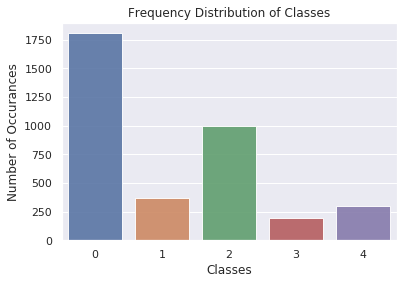

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
Class_Frequency_Count = df_train['diagnosis'].value_counts()
print(str(Class_Frequency_Count) + "\n")
sns.set(style="darkgrid")
sns.barplot(Class_Frequency_Count.index,Class_Frequency_Count.values,alpha=0.9)
plt.title("Frequency Distribution of Classes")
plt.ylabel("Number of Occurances", fontsize=12)
#plt.xticks(rotation=90)
plt.xlabel("Classes", fontsize=12)
plt.show()

In [0]:
!rm -rf Training_Dir
!rm -rf Validation_Dir

0    1805
2     999
1     740
4     735
3     673
Name: diagnosis, dtype: int64



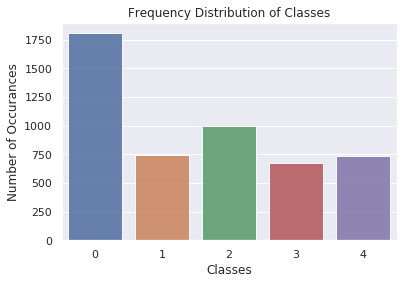

In [0]:
tempDiag = df_train['diagnosis'].tolist()
tempImag = df_train['id_code'].tolist()
imgTmp1 = []
imgTmp3 = []
imgTmp4 = []
count1=0
for i in range(len(tempDiag)):
  if tempDiag[i] == 1:
    count1 = count1+1
    imgTmp1.append(tempImag[i])
  elif tempDiag[i] == 3:
    imgTmp3.append(tempImag[i])
  elif tempDiag[i] == 4:
    imgTmp4.append(tempImag[i])
    
from PIL import Image
from PIL import ImageFilter


class_labels = []
added_images = []
imgTmp=[]
kl = [1,3,4]
for l in kl:
  if l == 1:
    imgTmp = imgTmp1[: int(len(imgTmp1) * .2)]
  elif l == 3:
    imgTmp = imgTmp3[: int(len(imgTmp3) * .50)]
  elif l == 4:
    imgTmp = imgTmp4[: int(len(imgTmp4) * .3)]
  for imagefile in imgTmp:
    
    
    ext = '.png'
    imagefile_ext = imagefile  + ext
    path = 'Train_Images/'
    imfile = path+imagefile_ext
    im=Image.open(imfile)
    im=im.convert("RGB")
    r,g,b=im.split()
    r=r.convert("RGB")
    g=g.convert("RGB")
    b=b.convert("RGB")
    im_blur=im.filter(ImageFilter.GaussianBlur)
    im_unsharp=im.filter(ImageFilter.UnsharpMask)

    
    im_r = 'r_'+imagefile
    im_g = 'g_'+imagefile
    im_b = 'b_'+imagefile
    im_bl = 'bl_'+imagefile
    im_un = 'un_'+imagefile
    r.save(path+im_r+ext)
    g.save(path+im_g+ext)
    b.save(path+im_b+ext)
    im_blur.save(path+im_bl+ext)
    im_unsharp.save(path+im_un+ext)
    class_labels.append(l)
    added_images.append(im_r)
    class_labels.append(l)
    added_images.append(im_g)
    class_labels.append(l)
    added_images.append(im_b)
    class_labels.append(l)
    added_images.append(im_bl)
    class_labels.append(l)
    added_images.append(im_un)

tempDiag = tempDiag + class_labels
tempImag = tempImag + added_images
df_train = pd.DataFrame(list(zip(tempImag,tempDiag)), 
               columns =['id_code', 'diagnosis'])

df_train = df_train.sample(frac=1).reset_index(drop=True)

Class_Frequency_Count = df_train['diagnosis'].value_counts()
print(str(Class_Frequency_Count) + "\n")
sns.set(style="darkgrid")
sns.barplot(Class_Frequency_Count.index,Class_Frequency_Count.values,alpha=0.9)
plt.title("Frequency Distribution of Classes")
plt.ylabel("Number of Occurances", fontsize=12)
#plt.xticks(rotation=90)
plt.xlabel("Classes", fontsize=12)
plt.show()

In [0]:
#df_train = df_train.sample(frac=1).reset_index(drop=True)

In [0]:
split = int(0.7 * len(df_train))

train_dataframe = df_train.iloc[:split]
val_dataframe = df_train.iloc[split:]

train_images = train_dataframe['id_code'].tolist()
train_labels = train_dataframe['diagnosis'].tolist()
val_images = val_dataframe['id_code'].tolist()
val_labels = val_dataframe['diagnosis'].tolist()

0    1250
2     735
1     530
4     490
3     461
Name: diagnosis, dtype: int64



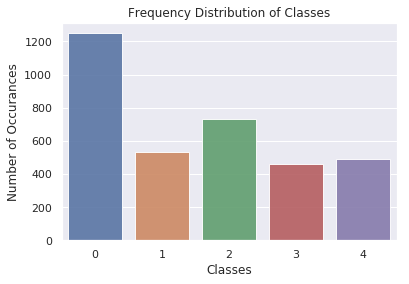

0    555
2    264
4    245
3    212
1    210
Name: diagnosis, dtype: int64



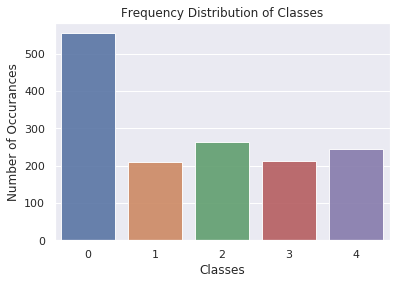

In [0]:
Train_Class_Frequency_Count = train_dataframe['diagnosis'].value_counts()
print(str(Train_Class_Frequency_Count) + "\n")
sns.set(style="darkgrid")
sns.barplot(Train_Class_Frequency_Count.index,Train_Class_Frequency_Count.values,alpha=0.9)
plt.title("Frequency Distribution of Classes")
plt.ylabel("Number of Occurances", fontsize=12)
#plt.xticks(rotation=90)
plt.xlabel("Classes", fontsize=12)
plt.show()


Val_Class_Frequency_Count = val_dataframe['diagnosis'].value_counts()
print(str(Val_Class_Frequency_Count) + "\n")
sns.set(style="darkgrid")
sns.barplot(Val_Class_Frequency_Count.index,Val_Class_Frequency_Count.values,alpha=0.9)
plt.title("Frequency Distribution of Classes")
plt.ylabel("Number of Occurances", fontsize=12)
#plt.xticks(rotation=90)
plt.xlabel("Classes", fontsize=12)
plt.show()

In [0]:
train_keyword = 'Training_Dir'
validation_keyword = 'Validation_Dir'
keywords = [train_keyword,validation_keyword]
dir_list = df_train['diagnosis'].tolist()

for keyword in keywords:
  if(not os.path.exists(keyword)):
    os.mkdir(keyword)
  for class_dir in dir_list:
    if(not os.path.exists(keyword+'/'+str(class_dir))):
      os.mkdir(keyword+'/'+str(class_dir))

In [0]:
for keyword in keywords:
  image_list = []
  class_list = []
  if(not os.path.exists(keyword)):
    os.mkdir(keyword)
  if keyword == train_keyword:
    image_list = train_images
    class_list = train_labels
  elif keyword == validation_keyword: 
    image_list = val_images
    class_list = val_labels
  for image_info in image_list:
    cl = class_list[image_list.index(image_info)]
    cf.copy('Train_Images/'+str(image_info)+'.png', keyword+'/'+str(cl))

In [0]:
train_dir = 'Training_Dir'
validation_dir = 'Validation_Dir'

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')


validation_datagen = ImageDataGenerator(rescale=1./255)
 
# Change the batchsize according to your system RAM
train_batchsize = 100
val_batchsize = 50
 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=train_batchsize,
        class_mode='categorical')
 
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)

Found 3466 images belonging to 5 classes.
Found 1486 images belonging to 5 classes.


In [0]:

def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(125, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(5, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [0]:
model =  build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 224, 224, 64)      1792      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2 (SeparableConv2D)      (None, 112, 112, 128)     8896      
_________________________________________________________________
bn2 (BatchNormalization)     (None, 112, 112, 128)     512       
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
Conv3 (SeparableConv2D)      (None, 56, 56, 256)       34176     
__________

In [0]:
opt = SGD(lr=0.0001,momentum=0.9)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

In [0]:
!rm -rf Test_Images
!rm -rf Train_Images

In [0]:
epochs = 15
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples//train_generator.batch_size ,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=validation_generator.samples//validation_generator.batch_size,
      verbose=1)

Epoch 1/15
34/34 [==============================] - 623s 18s/step - loss: 1.4276 - acc: 0.3968 - val_loss: 1.2645 - val_acc: 0.5110
Epoch 2/15
34/34 [==============================] - 482s 14s/step - loss: 1.2736 - acc: 0.4778 - val_loss: 1.1950 - val_acc: 0.5125
Epoch 3/15
34/34 [==============================] - 482s 14s/step - loss: 1.2215 - acc: 0.5015 - val_loss: 1.1477 - val_acc: 0.5474
Epoch 4/15
34/34 [==============================] - 486s 14s/step - loss: 1.2016 - acc: 0.5085 - val_loss: 1.1271 - val_acc: 0.5515
Epoch 5/15
34/34 [==============================] - 476s 14s/step - loss: 1.1733 - acc: 0.5256 - val_loss: 1.0934 - val_acc: 0.5550
Epoch 6/15
34/34 [==============================] - 482s 14s/step - loss: 1.1494 - acc: 0.5365 - val_loss: 1.0895 - val_acc: 0.5655
Epoch 7/15
34/34 [==============================] - 482s 14s/step - loss: 1.1562 - acc: 0.5252 - val_loss: 1.0982 - val_acc: 0.5453
Epoch 8/15
34/34 [==============================] - 478s 14s/step - loss: 1.

In [0]:
# Save Weights of the Model for Future Use
model.save_weights('Model_DepthSeparable.h5')

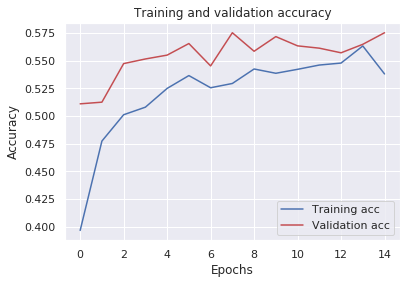

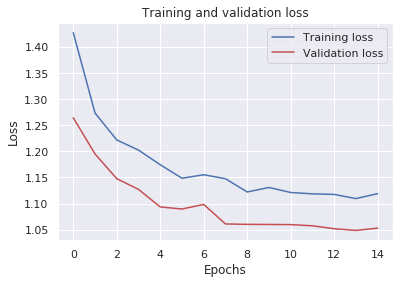

In [0]:
# Plot

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
# Max Accuracy

print("Validation Accuracy:", max(history.history['val_acc']))
print("Training Accuracy", max(history.history['acc']))

Validation Accuracy: 0.5752089151899877
Training Accuracy 0.5632798563704488
